<a href="https://colab.research.google.com/github/DreamyZero/kluster/blob/main/kluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Количество записей: 178
Количество признаков: 13
Количество классов: 3

Пропущенные значения:
 Alcohol                 0
Malic_acid              0
Ash                     0
Alcalinity_of_ash       0
Magnesium               0
Total_phenols           0
Flavanoids              0
Nonflavanoid_phenols    0
Proanthocyanins         0
Color_intensity         0
Hue                     0
OD280/OD315             0
Proline                 0
dtype: int64

Дубликаты: 0

Диапазоны признаков:
                          min      max
Alcohol                11.03    14.83
Malic_acid              0.74     5.80
Ash                     1.36     3.23
Alcalinity_of_ash      10.60    30.00
Magnesium              70.00   162.00
Total_phenols           0.98     3.88
Flavanoids              0.34     5.08
Nonflavanoid_phenols    0.13     0.66
Proanthocyanins         0.41     3.58
Color_intensity         1.28    13.00
Hue                     0.48     1.71
OD280/OD315             1.27     4.00
Proline               2

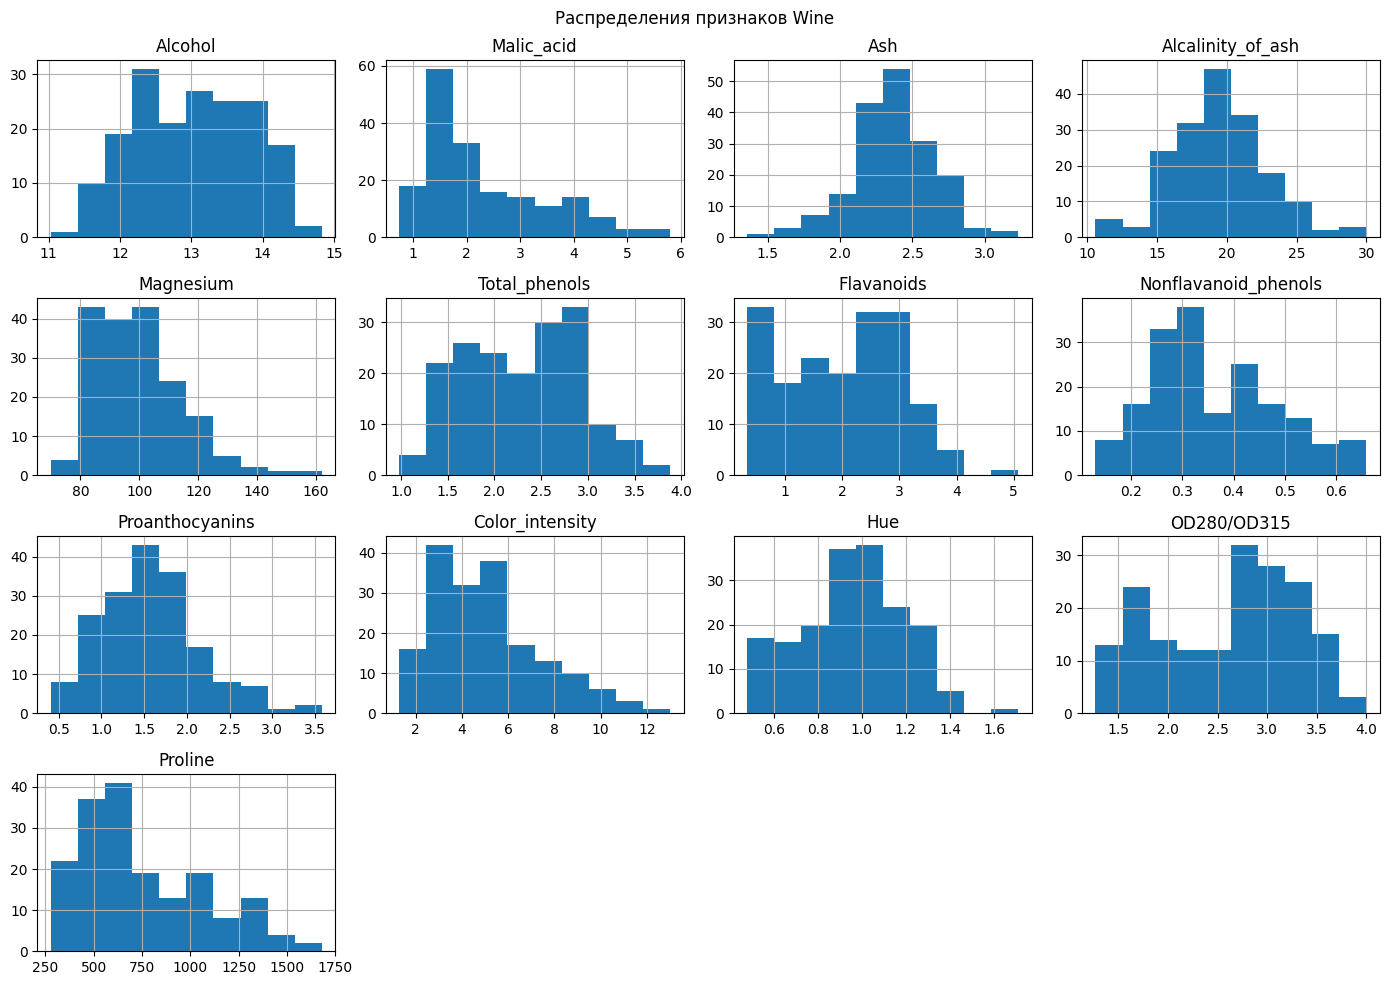


Сводная таблица метрик:
     inertia_mean  inertia_std  silhouette_mean  silhouette_std   db_mean  \
k                                                                          
2    1659.372579     0.448801         0.264785        0.004327  1.478146   
3    1279.029497     1.225124         0.284334        0.001402  1.390749   
4    1195.782043    15.371540         0.237647        0.022205  1.738522   
5    1128.295633    18.627194         0.204180        0.033939  1.792340   
6    1073.330236    14.985108         0.164203        0.034201  1.899789   
7    1018.885817    21.036655         0.156762        0.030078  1.858764   
8     968.015020    21.520200         0.150303        0.025079  1.844558   
9     925.705100    16.003867         0.136400        0.019261  1.819702   
10    890.437218    21.542039         0.132163        0.011523  1.778139   

      db_std    ch_mean    ch_std  
k                                  
2   0.036691  69.432542  0.066373  
3   0.001711  70.803765  0.15

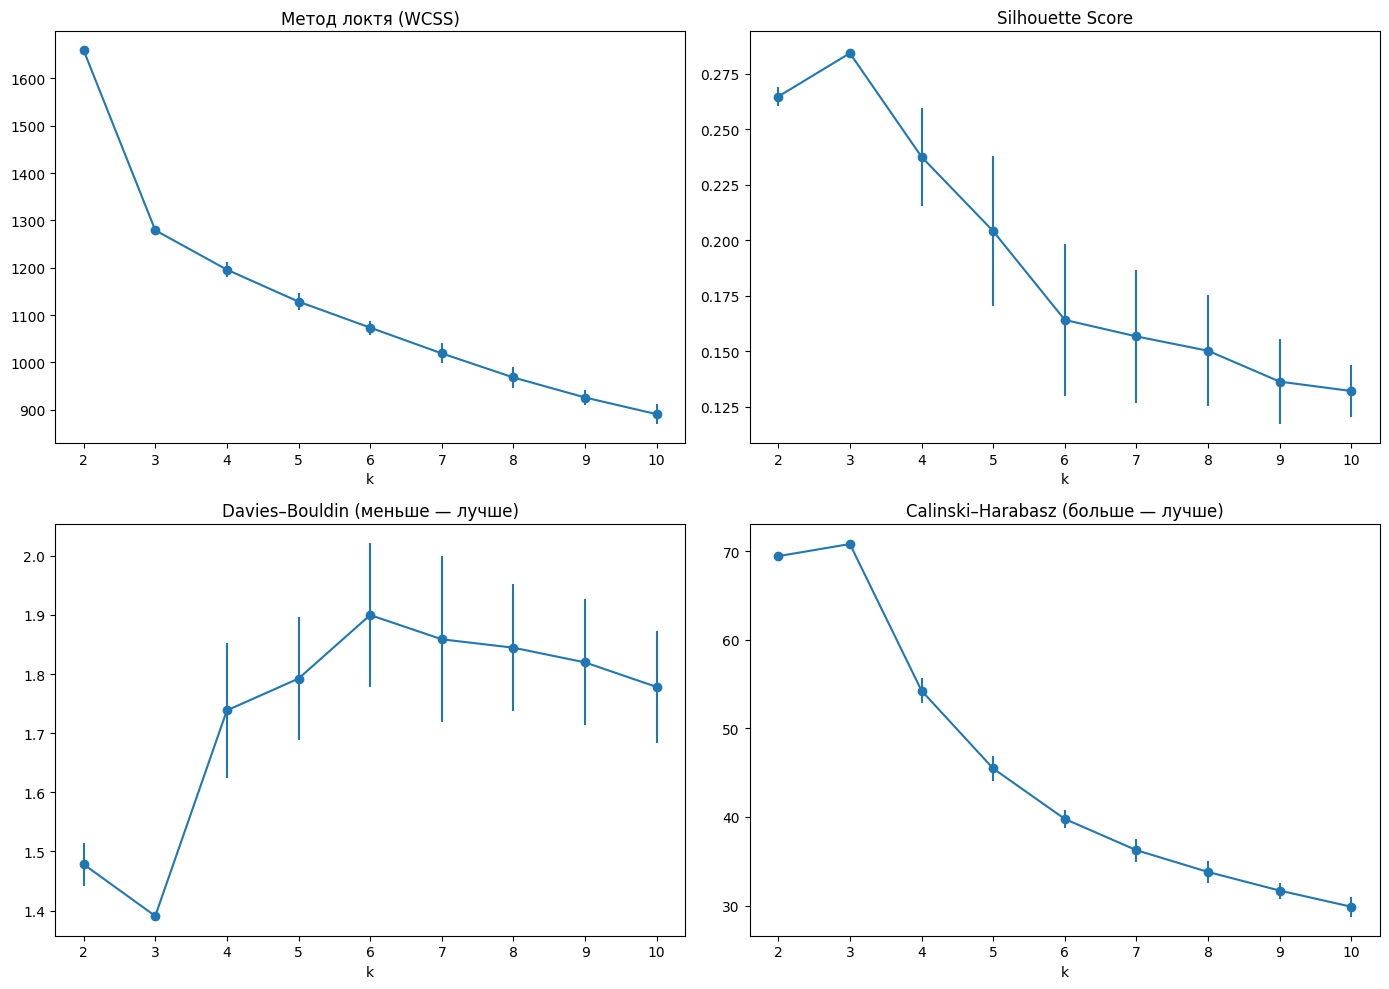


Внутренние метрики для k = 3
Silhouette: 0.2848589191898987
Davies–Bouldin: 1.3891879777181648
Calinski–Harabasz: 70.94000800315118

Внешние метрики (не использовались для подбора k):
ARI: 0.8974949815093207
NMI: 0.8758935341223069


In [1]:
# =========================================
# 1. Импорт библиотек
# =========================================
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

import warnings
warnings.filterwarnings("ignore")

# =========================================
# 2. Загрузка данных из ZIP
# =========================================
ZIP_PATH = '/mnt/data/wine.zip'
EXTRACT_DIR = '/mnt/data/wine'
DATA_FILE = os.path.join(EXTRACT_DIR, 'wine.data')

if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(EXTRACT_DIR)

columns = [
    'Class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium',
    'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins',
    'Color_intensity', 'Hue', 'OD280/OD315', 'Proline'
]

df = pd.read_csv(DATA_FILE, names=columns)
X = df.drop(columns='Class')
y_true = df['Class']

print("Количество записей:", X.shape[0])
print("Количество признаков:", X.shape[1])
print("Количество классов:", y_true.nunique())

# 3. Первичный анализ данных

print("\nПропущенные значения:\n", X.isna().sum())
print("\nДубликаты:", X.duplicated().sum())

# Диапазоны значений
ranges = X.describe().T[['min', 'max']]
print("\nДиапазоны признаков:\n", ranges)

# Распределения
X.hist(figsize=(14, 10))
plt.suptitle("Распределения признаков Wine")
plt.tight_layout()
plt.show()

# 4. Масштабирование
scalers = {
    "standard": StandardScaler(), #объяснить
}

X_scaled = {name: scaler.fit_transform(X) for name, scaler in scalers.items()}

# Основной выбор — StandardScaler:
# k-means минимизирует евклидово расстояние,
# признаки имеют разные масштабы.

# 5. Подбор числа кластеров
K_RANGE = range(2, 11)
N_INIT = 15

results = []

for k in K_RANGE:
    inertias, sils, dbs, chs = [], [], [], []

    for seed in range(N_INIT):
        kmeans = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=1,
            random_state=seed
        )

        labels = kmeans.fit_predict(X_scaled['standard'])

        inertias.append(kmeans.inertia_)
        sils.append(silhouette_score(X_scaled['standard'], labels))
        dbs.append(davies_bouldin_score(X_scaled['standard'], labels))
        chs.append(calinski_harabasz_score(X_scaled['standard'], labels))

    results.append({
        'k': k,
        'inertia_mean': np.mean(inertias),
        'inertia_std': np.std(inertias),
        'silhouette_mean': np.mean(sils),
        'silhouette_std': np.std(sils),
        'db_mean': np.mean(dbs),
        'db_std': np.std(dbs),
        'ch_mean': np.mean(chs),
        'ch_std': np.std(chs)
    })

results_df = pd.DataFrame(results).set_index('k')
print("\nСводная таблица метрик:\n", results_df)

# 6. Визуализация метрик по k
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.errorbar(results_df.index, results_df['inertia_mean'],
             yerr=results_df['inertia_std'], marker='o')
plt.title("Метод локтя (WCSS)")
plt.xlabel("k")

plt.subplot(2, 2, 2)
plt.errorbar(results_df.index, results_df['silhouette_mean'],
             yerr=results_df['silhouette_std'], marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")

plt.subplot(2, 2, 3)
plt.errorbar(results_df.index, results_df['db_mean'],
             yerr=results_df['db_std'], marker='o')
plt.title("Davies–Bouldin (меньше — лучше)")
plt.xlabel("k")

plt.subplot(2, 2, 4)
plt.errorbar(results_df.index, results_df['ch_mean'],
             yerr=results_df['ch_std'], marker='o')
plt.title("Calinski–Harabasz (больше — лучше)")
plt.xlabel("k")

plt.tight_layout()
plt.show()

# 7. Финальный выбор k
k_final = 3

kmeans_final = KMeans(
    n_clusters=k_final,
    init='k-means++',
    n_init=20,
    random_state=42
)

labels_final = kmeans_final.fit_predict(X_scaled['standard'])

# 8. Оценка качества кластеризации
print("\nВнутренние метрики для k =", k_final)
print("Silhouette:", silhouette_score(X_scaled['standard'], labels_final))
print("Davies–Bouldin:", davies_bouldin_score(X_scaled['standard'], labels_final))
print("Calinski–Harabasz:", calinski_harabasz_score(X_scaled['standard'], labels_final))

print("\nВнешние метрики (не использовались для подбора k):")
print("ARI:", adjusted_rand_score(y_true, labels_final))
print("NMI:", normalized_mutual_info_score(y_true, labels_final)) #объяснить
